In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import nltk
nltk.download('stopwords')
from collections import defaultdict
from array import array
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import numpy as np
from numpy import linalg as la
nltk.download('punkt')
import re
import pandas as pd
import json
from wordcloud import WordCloud
from more_itertools import sort_together
from matplotlib import pyplot as plt
from datetime import datetime
import time
import math
import collections
from gensim.models.word2vec import Word2Vec
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\eduar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\eduar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
%cd /content/drive/MyDrive/IRWA Project summary and first deliverable-20231015

/content/drive/MyDrive/IRWA Project summary and first deliverable-20231015


# Part 1 Text Processing and Exploratory Data Analysis

## **1. Pre-processing**

In [2]:
docs_path = 'IRWA_data_2023/Rus_Ukr_war_data.json'
with open(docs_path) as fp:
    lines = fp.readlines()
lines = [l.strip().replace(' +', ' ') for l in lines]

### Define the preporocessing functions we will use

In [3]:
def exteract_url(entities):
    try:
        # delete last 2 slashed from 'https://twitter.com/{user_name}/status/{tweet_id}/video/1' considering it could be different than /video/1
        arr_url = entities['media'][0]['expanded_url'].split('|')
        return "/".join(arr_url[:-2])
    except KeyError:
        return ''

In [4]:
pd.options.mode.chained_assignment = None  # default='warn'
# we convert data to json to structure the lines into a data structure that can be then transformed into a pandas dataframe
datos_diccionario = [json.loads(line) for line in lines]
datos_diccionario_pd = pd.DataFrame(datos_diccionario)
useful_columns_df = datos_diccionario_pd[['id', 'created_at', 'full_text', 'favorite_count', 'retweet_count']]
useful_columns_df['hashtags'] = datos_diccionario_pd['entities'].apply(lambda x: [d['text'] for d in x['hashtags']])
useful_columns_df['url'] = datos_diccionario_pd['entities'].apply(exteract_url)

In [5]:
def preprocess(full_text):
    url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    full_text=  full_text.lower()
    # rename all urls
    full_text = re.sub(url_pattern, '', full_text)
    # remove all words that start with #
    full_text = re.sub(r'#\w+', '', full_text)
    return full_text

In [6]:
#preprocess
def build_terms(line, tokenize=True):
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words("english"))

    line = preprocess(line)

    line=  nltk.tokenize.word_tokenize(line) ## Tokenize the text to get a list of terms
    #here we have to decide if remove # or not and explain why
    line=[word for word in line if re.match(r'^\w+$', word)] ## remove punctuation
    line=[word for word in line if word not in stop_words]  ##eliminate the stopwords
    line=[nltk.stem.SnowballStemmer('english').stem(word) for word in line] ## perform stemming )

    if tokenize:
        return line
    else:
        return ' '.join(line)

### Create mapping between tweets and document id's

In [7]:
tweet_info = {}
for indexes, row in useful_columns_df.iterrows():
    # create dictionary with tweet_id and document information structures as such: Tweet | Date | Hashtags | Likes | Retweets | Url
    tweet_info[row['id']] = " || ".join([row['full_text'], row['created_at'], " ".join(row['hashtags']),
                                        str(row['favorite_count']), str(row['retweet_count']), row['url']])

## **2. Exploratory Data Analysis**

In [8]:
# we preprocess all the data to obtain terms[i] which is data preprocessed,
terms_wo_hastags = [build_terms(row['full_text']) for _, row in useful_columns_df.iterrows()]
terms_with_hastags = [build_terms(row['full_text']) + row['hashtags'] for _, row in useful_columns_df.iterrows()]

### Word count boxplot

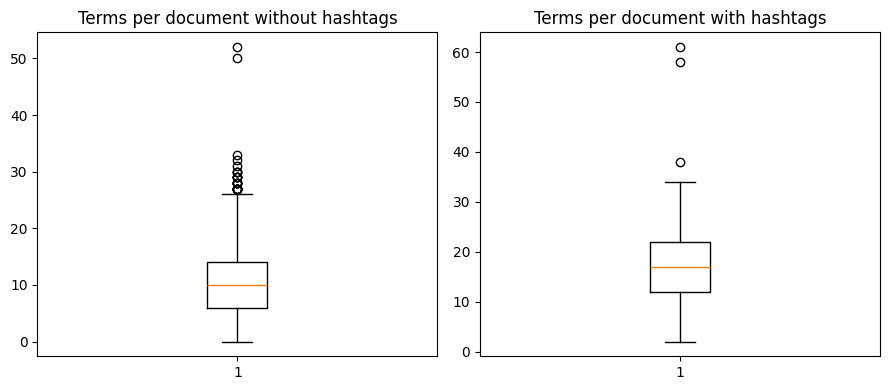

In [9]:
# display a boxplot of the number of terms per document (with and without hashtags) into one same figure with 2 columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
axes[0].boxplot([len(doc) for doc in terms_wo_hastags])
axes[0].set_title('Terms per document without hashtags')
axes[1].boxplot([len(doc) for doc in terms_with_hastags])
axes[1].set_title('Terms per document with hashtags')
fig.tight_layout()
plt.show()

### Historic number of tweets per day

In [10]:
def convert_date(str_date):
    date_array = str_date.split(' ')
    date_array[-2] = '+'+date_array[-2]
    str_date_mod = " ".join(date_array)
    return datetime.strptime(str_date_mod, '%a %b %d %H:%M:%S %z %Y').date()

In [11]:
useful_columns_df['created_at'] = useful_columns_df['created_at'].apply(convert_date)


In [12]:
useful_columns_df['created_at'].unique()

array([datetime.date(2022, 9, 30), datetime.date(2022, 9, 29),
       datetime.date(2022, 9, 28)], dtype=object)

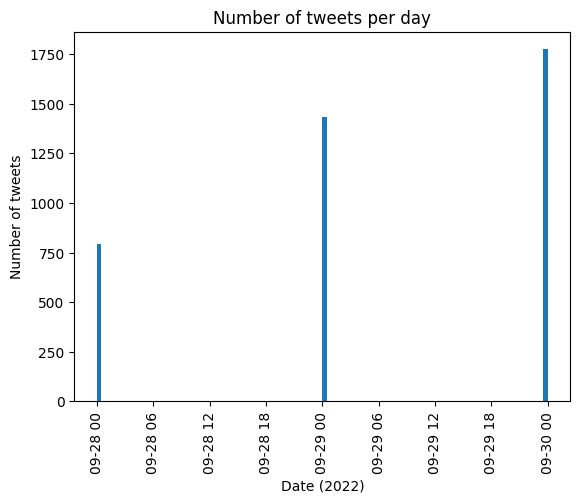

In [13]:
# create a histogram with the number of tweets per day and have the dates in the x-axis be vertically oriented
plt.hist(useful_columns_df['created_at'], bins=100)
plt.xlabel('Date (2022)')
plt.xticks(rotation=90)
plt.ylabel('Number of tweets')
plt.title('Number of tweets per day')
plt.show()


### Get the 10 most retweeted and saves as favourite tweets

In [16]:
retweet_counts = []
textos = []

for dato in datos_diccionario:
    retweet_counts.append(dato['retweet_count'])
    textos.append(dato['full_text'])

inv_ord_retweed=list(sort_together([retweet_counts, textos])[1])
for i in range(-1,-11,-1):
  print(-i,' tweet with more retweets: ',inv_ord_retweed[i],'\n')

1  tweet with more retweets:  🗺️Situation around Lyman - Sep 30 11:00:
- UA forces liberated Yampil and advancing north
- RU troops are reportedly abandoning its positions in Drobysheve
- The only exit route from Lyman is within the firing range of UA forces
#UkraineRussiaWar https://t.co/jGJUhXcr1y 

2  tweet with more retweets:  📷Unique and rare photos of Ukrainian forward command post during the offensive in #Kharkiv Oblast. News reporters aren't usually invited to such places, but here seems to be an exception.
#UkraineRussiaWar https://t.co/AmSijyM59c 

3  tweet with more retweets:  📽️Operation Interflex: Ukrainian recruits continue to master their skills under the guidance of British and Canadian instructors in the UK.
#UkraineRussiaWar https://t.co/oYWThs8qNe 

4  tweet with more retweets:  The following countries have urged their citizens to leave 🇷🇺 will update if other governments make similar statements. 
#UkraineRussiaWar #AnnexationofUkraine
#NAFO 

Poland 🇵🇱
Estonia 🇪🇪
La

In [17]:
favourite_counts = []
textos = []

for dato in datos_diccionario:
    favourite_counts.append(dato['favorite_count'])
    textos.append(dato['full_text'])

inv_ord_favourite=list(sort_together([favourite_counts, textos])[1])
for i in range(-1,-11,-1):
  print(-i,' tweet with favourite additions: ',inv_ord_favourite[i],'\n')

1  tweet with favourite additions:  🗺️Situation around Lyman - Sep 30 11:00:
- UA forces liberated Yampil and advancing north
- RU troops are reportedly abandoning its positions in Drobysheve
- The only exit route from Lyman is within the firing range of UA forces
#UkraineRussiaWar https://t.co/jGJUhXcr1y 

2  tweet with favourite additions:  📷Unique and rare photos of Ukrainian forward command post during the offensive in #Kharkiv Oblast. News reporters aren't usually invited to such places, but here seems to be an exception.
#UkraineRussiaWar https://t.co/AmSijyM59c 

3  tweet with favourite additions:  📽️Operation Interflex: Ukrainian recruits continue to master their skills under the guidance of British and Canadian instructors in the UK.
#UkraineRussiaWar https://t.co/oYWThs8qNe 

4  tweet with favourite additions:  📷🇨🇿 Czech volunteer during the ongoing offensive of Ukrainian Forces in #Kharkiv Oblast. #UkraineRussiaWar https://t.co/u9tnLGvXlw 

5  tweet with favourite additions:

### Worldcould of most frequent words for tweets considering hashtags and not

In [14]:
def matrix_to_line(matrix):
    return " ".join([item for sublist in matrix for item in sublist])

Text(0.5, 1.0, 'Word Cloud for....')

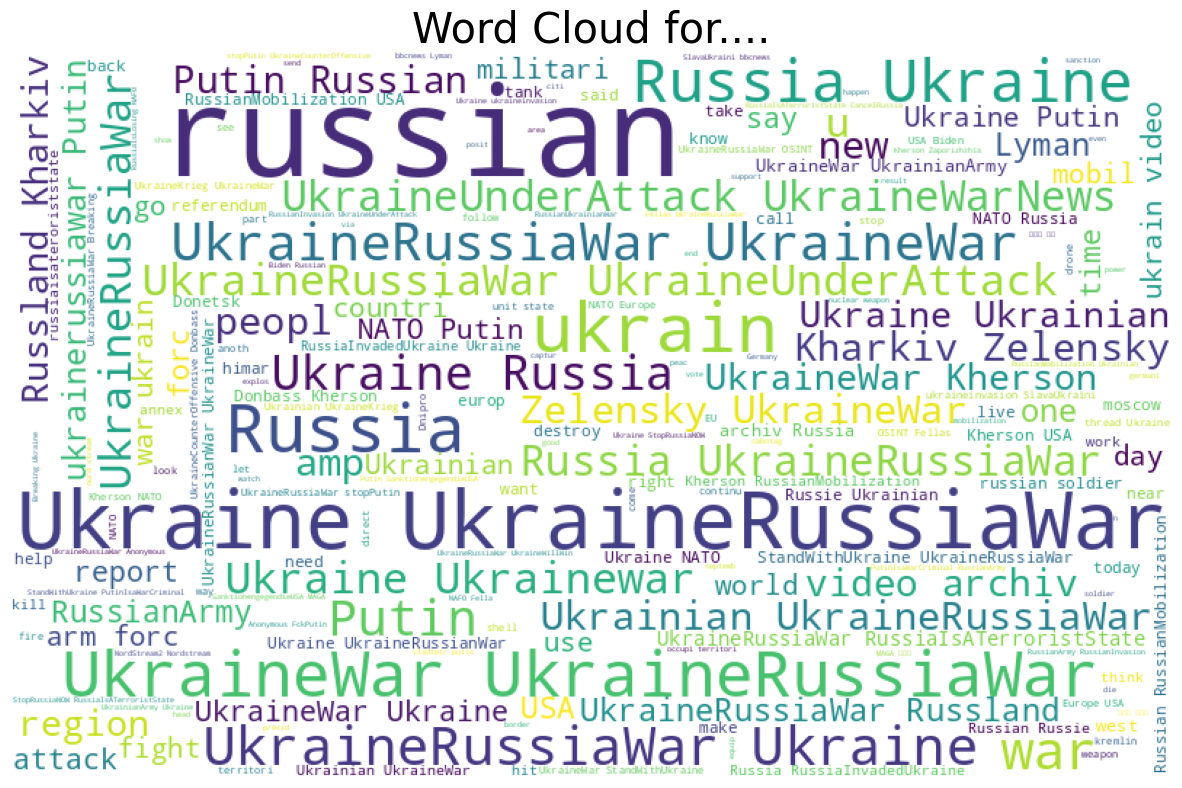

In [19]:
# Generate a wordcloud for our dataset
# Generating wordcloud using the text concatenated
plt.figure(figsize=(15, 15))
wc = WordCloud(background_color='white',
               width=800,
               height=500).generate(matrix_to_line(terms_with_hastags))
plt.imshow(wc)
plt.axis('off')
plt.title('Word Cloud for....', fontsize=30)

Text(0.5, 1.0, 'Word Cloud for....')

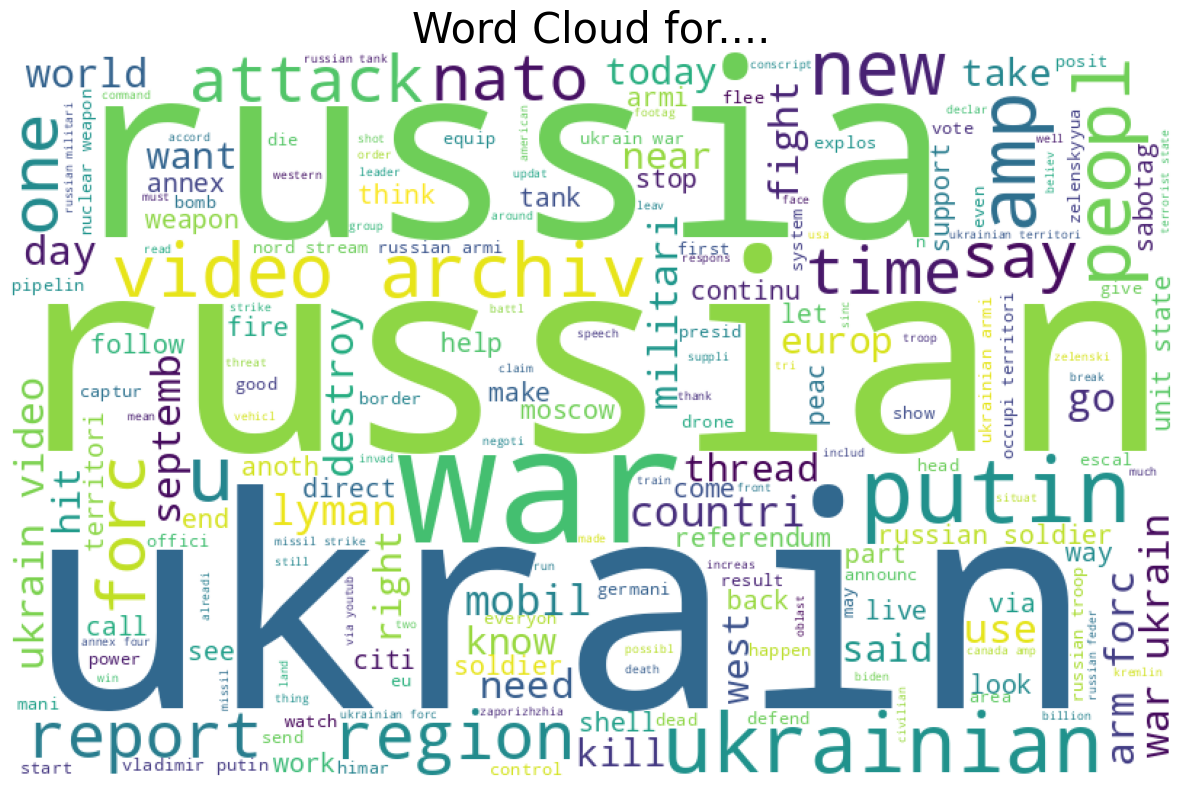

In [20]:
# Generate a wordcloud for our dataset
# Generating wordcloud using the text concatenated
plt.figure(figsize=(15, 15))
wc = WordCloud(background_color='white',
               width=800,
               height=500).generate(matrix_to_line(terms_wo_hastags))
plt.imshow(wc)
plt.axis('off')
plt.title('Word Cloud for....', fontsize=30)

# Part 2 Indexing and Evaluation

In [9]:
docs_path = 'IRWA_data_2023/Rus_Ukr_war_data_ids.csv'
with open(docs_path) as fp:
    lines = fp.readlines()
doc_num_id = [l.replace("\t", ' ').strip() for l in lines]


In [10]:
# create dictionaries to obtain the tweet_id from the document number and viceversa
id_to_doc_num=dict()
doc_num_to_id=dict()
for i in range(len(doc_num_id)):
  id_to_doc_num[int(doc_num_id[i].split(' ')[1])]=doc_num_id[i].split(' ')[0]
  doc_num_to_id[doc_num_id[i].split(' ')[0]]=int(doc_num_id[i].split(' ')[1])

##  **Indexing**

### **Build inverted index**

In [11]:
def create_index(lines, id_to_doc_num):
    """
    Implement the inverted index

    Argument:
    lines -- collection of tweets

    Returns:
    index - the inverted index (implemented through a Python dictionary) containing terms as keys and the corresponding
    list of tweets where these keys appears in (and the positions) as values.
    """
    index = defaultdict(list)

    for tweet_id, line in lines.items():
        line = line.split(' || ')
        doc_number = id_to_doc_num[tweet_id]
        terms = build_terms(line[0] + line[2]) # include hashtags
        current_page_index = {}
        for position, term in enumerate(terms): # terms contains page_title + page_text. Loop over all terms
            try:
                # if the term is already in the index for the current page (current_page_index)
                # append the position to the corresponding list
                current_page_index[term][1].append(position)
            except:
                # Add the new term as dict key and initialize the array of positions and add the position
                current_page_index[term]=[doc_number, array('I',[position])] #'I' indicates unsigned int (int in Python)

        #merge the current page index with the main index
        for term_page, posting_page in current_page_index.items():
            index[term_page].append(posting_page)
    return index

In [12]:
start_time = time.time()
index_table = create_index(tweet_info, id_to_doc_num)
print("Total time to create the index: {} seconds".format(np.round(time.time() - start_time, 2)))

Total time to create the index: 7.32 seconds


### **Test Queries**

Define five queries that will be used to evaluate your search
engine (e.g., “presidents visiting Kyiv”, “countries supporting Ukraine”)

**Approach 1 : For the test queries select from the most frequent terms in the following collections**

terms_with_hastags

terms_wo_hastags

In [13]:
term_freq = defaultdict(int)
for doc in terms_with_hastags:
    for term in doc:
        term_freq[term] += 1
#select top terms with highest frequency
top_terms = sorted(term_freq.items(), key=lambda x: x[1], reverse=True)[:20]

In [14]:
top_terms

[('UkraineRussiaWar', 3851),
 ('Ukraine', 2039),
 ('Russia', 1156),
 ('UkraineWar', 1101),
 ('ukrain', 959),
 ('russian', 876),
 ('russia', 666),
 ('Putin', 527),
 ('putin', 525),
 ('war', 520),
 ('Russian', 472),
 ('ukrainian', 454),
 ('NATO', 439),
 ('Kherson', 434),
 ('Ukrainian', 407),
 ('USA', 382),
 ('Kharkiv', 318),
 ('UkraineUnderAttack', 311),
 ('forc', 276),
 ('UkraineWarNews', 273)]

With top terms we can define following test queries : "Ukraine Russia War", "putin", "nato", "kherson", "kharkiv"

**Approach 2 : To define queries with more words appearing together, we search for pairs of terms with highest frequency.**
**pairs of terms as keys and the number of times they appear together in the collection as values**

In [15]:
term_pairs = defaultdict(int)
for doc in terms_with_hastags:
    for i in range(len(doc) - 1):
        term_pairs[(doc[i], doc[i + 1])] += 1

#select pairs of terms with highest frequency
sorted_pairs = sorted(term_pairs.items(), key=lambda x: x[1], reverse=True)[:40]

sorted_pairs

[(('Ukraine', 'UkraineRussiaWar'), 681),
 (('Russia', 'Ukraine'), 366),
 (('UkraineWar', 'UkraineRussiaWar'), 308),
 (('UkraineRussiaWar', 'UkraineWar'), 297),
 (('UkraineRussiaWar', 'UkraineUnderAttack'), 228),
 (('Ukraine', 'Russia'), 215),
 (('UkraineRussiaWar', 'Ukraine'), 214),
 (('UkraineUnderAttack', 'UkraineWarNews'), 208),
 (('Zelensky', 'UkraineWar'), 169),
 (('Ukrainian', 'UkraineRussiaWar'), 167),
 (('Kharkiv', 'Zelensky'), 165),
 (('Putin', 'Russian'), 146),
 (('video', 'archiv'), 145),
 (('UkraineWar', 'Kherson'), 136),
 (('Ukrainewar', 'UkraineRussiaWar'), 135),
 (('Russland', 'Kharkiv'), 134),
 (('Ukraine', 'Ukrainewar'), 131),
 (('UkraineRussiaWar', 'Russland'), 130),
 (('Russia', 'UkraineRussiaWar'), 122),
 (('Ukraine', 'Ukrainian'), 119),
 (('NATO', 'Putin'), 87),
 (('UkraineWar', 'Ukraine'), 87),
 (('arm', 'forc'), 85),
 (('ukrain', 'video'), 84),
 (('Ukraine', 'Putin'), 83),
 (('UkraineRussiaWar', 'Ukraine️'), 82),
 (('Ukraine', 'UkraineWar'), 80),
 (('war', 'ukrai

With top pairs of terms we can define following test queries :  "Zelensky in Ukraine war ", "putin and nato", "is russia terrorist state ", "forces in kherson", "ukrain in nato"

In [16]:
our_queries = {"Q1": 'Zelensky in Ukraine war', "Q2": 'ukraine and nato', "Q3": 'is russia terrorist state',
               "Q4": 'forces in kherson', "Q5": 'russia attack on ukraine'}

In [17]:
def search(query, index):
    """
    The output is the list of documents that contain any of the query terms.
    So, we will get the list of documents for each query term, and take the union of them.
    """
    query = build_terms(query)
    docs = set()
    for term in query:
        try:
            # store in term_docs the ids of the docs that contain "term"
            term_docs=[posting[0] for posting in index[term]]
            # docs = docs Union term_docs
            docs = docs.union(term_docs)
        except KeyError:
            #term is not in index
            pass

    docs = list(docs)
    return docs

In [18]:
# choose randomly any query from our_queries
query = our_queries['Q1']
docs = search(query, index_table)
top = 5
# info = [tweet_info[doc_num_to_id[doc]] for doc in docs]
print("\n======================\nSample of {} results out of {} for the searched query:\n".format(top, len(docs)))
for d_id in docs[:top]:
    print("doc_number= {},info_tweet={} ".format(d_id,tweet_info[doc_num_to_id[d_id]]))
    print("\n\n")


Sample of 5 results out of 2131 for the searched query:

doc_number= doc_1382,info_tweet=A faithful dog named Krym, who does not leave his destroyed home. The whole family of a grandmother, a mother and two children died under the debris.
Yesterday, a Russian rocket flew into the city of Dnipro. #Dnipro #Dnepropetrovsk #UkraineRussiaWar #Ukraine #RussiaisATerroist https://t.co/56jdDO1SMA || Fri Sep 30 07:05:10 0000 2022 || Dnipro Dnepropetrovsk UkraineRussiaWar Ukraine RussiaisATerroist || 1 || 0 ||  



doc_number= doc_3447,info_tweet=If things aren't called by their names &amp; what you see is not what you get, you won't know what to do to fix the situation?

https://t.co/7yGCp8m5ED

You voted blue in 2020
How's your life shaping up?

#Biden #Trump #TrumpCult #GQP #racism #BLM #Ukraine #UkraineRussiaWar #Russia || Wed Sep 28 20:49:42 0000 2022 || Biden Trump TrumpCult GQP racism BLM Ukraine UkraineRussiaWar Russia || 4 || 4 ||  



doc_number= doc_592,info_tweet=👏Footage of a Russia

### **Ranking**
Implement the TF-IDF algorithm and provide ranking based
results

In [19]:
def create_index_tfidf(lines, num_documents):
    """
    Implement the inverted index and compute tf, df and idf

    Argument:
    lines -- collection of tweets
    num_documents -- total number of documents

    Returns:
    index - the inverted index (implemented through a Python dictionary) containing terms as keys and the corresponding
    list of tweets these keys appears in (and the positions) as values.
    tf - normalized term frequency for each term in each document
    df - number of documents each term appear in
    idf - inverse document frequency of each term
    """
    index = defaultdict(list)
    tf = defaultdict(list)  # term frequencies of terms in documents (documents in the same order as in the main index)
    df = defaultdict(int)  # document frequencies of terms in the corpus
    idf = defaultdict(float)
    for tweet_id, line in lines.items():
        line = line.split('||')
        doc_number = id_to_doc_num[tweet_id]
        terms = build_terms(line[0] + line[2]) #text+?? hastag
        current_page_index = {}
        for position, term in enumerate(terms): # terms contains page_title + page_text. Loop over all terms
            try:
                # if the term is already in the index for the current page (current_page_index)
                # append the position to the corresponding list
                current_page_index[term][1].append(position)
            except:
                # Add the new term as dict key and initialize the array of positions and add the position
                current_page_index[term]=[doc_number, array('I',[position])] #'I' indicates unsigned int (int in Python)

        #normalize term frequencies
        # Compute the denominator to normalize term frequencies (formula 2 above)
        # norm is the same for all terms of a document.
        norm = 0
        for term, posting in current_page_index.items():
          # posting will contain the list of positions for current term in current document.
          # posting ==> [current_doc, [list of positions]]
          # you can use it to infer the frequency of current term.
          norm += len(posting[1]) ** 2
        norm = math.sqrt(norm)

      # calculate the tf(dividing the term frequency by the above computed norm) and df weights
        for term, posting in current_page_index.items():
          # append the tf for current term (tf = term frequency in current doc/norm)
          tf[term].append(np.round(len(posting[1])/norm,4)) ## SEE formula (1) above
          #increment the document frequency of current term (number of documents containing the current term)
          df[term] +=1 # increment DF for current term

      #merge the current page index with the main index
        for term_page, posting_page in current_page_index.items():
          index[term_page].append(posting_page)

        for term in df:
          idf[term] = np.round(np.log(float(num_documents/df[term])), 4)


    return index, tf, df, idf




def rank_documents(terms, docs, index, idf, tf):
    """
    Perform the ranking of the results of a search based on the tf-idf weights

    Argument:
    terms -- list of query terms
    docs -- list of tweets, to rank, matching the query
    index -- inverted index data structure
    idf -- inverted document frequencies
    tf -- term frequencies
    title_index -- mapping between page id and page title

    Returns:
    Print the list of ranked documents
    """
     # I'm interested only on the element of the docVector corresponding to the query terms
    # The remaining elements would became 0 when multiplied to the query_vector
    doc_vectors = defaultdict(lambda: [0] * len(terms)) # I call doc_vectors[k] for a nonexistent key k, the key-value pair (k,[0]*len(terms)) will be automatically added to the dictionary
    query_vector = [0] * len(terms)

    # compute the norm for the query tf
    query_terms_count = collections.Counter(terms)  # get the frequency of each term in the query.
    # Example: collections.Counter(["hello","hello","world"]) --> Counter({'hello': 2, 'world': 1})
    # HINT: use when computing tf for query_vector

    query_norm = la.norm(list(query_terms_count.values()))

    for termIndex, term in enumerate(terms):  #termIndex is the index of the term in the query
        if term not in index:
            continue

        ## Compute tf*idf(normalize TF as done with documents)

        query_vector[termIndex]=tf[term][termIndex]/np.sqrt(sum(np.power(tf[term],2))) * idf[term]

        # Generate doc_vectors for matching docs
        for doc_index, (doc, postings) in enumerate(index[term]):

            #tf[term][0] will contain the tf of the term "term" in the doc 26
            if doc in docs:
                doc_vectors[doc][termIndex] = tf[term][doc_index] * idf[term]  # TODO: check if multiply for idf



    doc_scores=[[np.dot(curDocVec, query_vector), doc] for doc, curDocVec in doc_vectors.items() ]
    doc_scores.sort(reverse=True)
    result_docs = [x[1] for x in doc_scores]
    #print document titles instead if document id's
    #result_docs=[ title_index[x] for x in result_docs ]
    if len(result_docs) == 0:
        print("No results found, try again")
        query = input()
        docs = search_tf_idf(query, index)
    #print ('\n'.join(result_docs), '\n')
    return result_docs


def search_tf_idf(query, index):
    """
    output is the list of documents that contain any of the query terms.
    So, we will get the list of documents for each query term, and take the union of them.
    """
    query = build_terms(query)
    docs = set()
    for term in query:
        try:
            # store in term_docs the ids of the docs that contain "term"
            term_docs=[posting[0] for posting in index[term]]
            # docs = docs Union term_docs
            docs = docs.union(term_docs)
        except KeyError:
            #term is not in index
            pass
    docs = list(docs)
    ranked_docs = rank_documents(query, docs, index, idf, tf)
    return ranked_docs

In [20]:
start_time = time.time()
num_documents = len(tweet_info)
index, tf, df, idf = create_index_tfidf(tweet_info, num_documents)
print("Total time to create the index: {} seconds" .format(np.round(time.time() - start_time, 2)))

Total time to create the index: 269.86 seconds


In [21]:
query = our_queries['Q1']
ranked_docs = search_tf_idf(query, index)
top = 5

print("\n======================\nTop {} results out of {} for the searched query:\n".format(top, len(ranked_docs)))
for d_id in ranked_docs[:top]:
    print("doc_number= {},info_tweet= {} ".format(d_id,tweet_info[doc_num_to_id[d_id]]))
    print("\n\n")


Top 5 results out of 2633 for the searched query:

doc_number= doc_557,info_tweet= Why Mr. #Putin, why? 😳👇
#Ukraine #Russia #War #NoWar #Zelensky #Zelenski #StopRussia #UkraineRussiaWar #StandWithUkraine #Ukrayna #Rusya
https://t.co/5IShVMUE4D || Fri Sep 30 13:25:14 0000 2022 || Putin Ukraine Russia War NoWar Zelensky Zelenski StopRussia UkraineRussiaWar StandWithUkraine Ukrayna Rusya || 0 || 0 ||  



doc_number= doc_417,info_tweet= 🇺🇦🇷🇺Ukraine will not hold any negotiations with Russia while Putin is president, Zelensky stated (September 30, 2022).

#Ukraine #Ukrainewar #UkraineRussiaWar #Zelensky || Fri Sep 30 14:50:53 0000 2022 || Ukraine Ukrainewar UkraineRussiaWar Zelensky || 1 || 0 ||  



doc_number= doc_1162,info_tweet= #UkraineRussiaWar #Nazi #Zelensky your time will come https://t.co/wVvcSRTual || Fri Sep 30 09:59:42 0000 2022 || UkraineRussiaWar Nazi Zelensky || 0 || 0 ||  



doc_number= doc_96,info_tweet= @zeitonline And it will get an accelerated reject. #Zelensky #Ukra

## **Evaluation**

### **Extract queries from information needs**

1. Using a subset of the dataset, we will provide you a baseline with 3
information needs (for which you should formulate the respective queries),
and the ground truth files for each query ( evaluation_gt file from part 1).

* a. Information need 1: What is the discussion regarding a tank in
Kharkiv?

* b. Information need 2: What discussions are there about the Nord
Stream pipeline?

* c. Information need 3: What is being said about the annexation of
territories by Russia?

In order to find the queries that satisfy the Evaluation_gt, we will search for the words in common between the documents valid with the queries and delete those that appear in those that don't

In [22]:
def extract_query(tweet_info, doc_num_to_id, positive_docs, negative_docs, information_needs):
    """
    Extract the query terms from the positive and negative documents

    Argument:
    positive_docs -- list of positive documents
    negative_docs -- list of negative documents

    Returns:
    query -- list of query terms
    """
    need_info = set(build_terms(information_needs))
    query_info = list()
    for doc in positive_docs:
        line = tweet_info[doc_num_to_id[doc]]
        line = line.split('||')
        terms = set(build_terms(line[0] + line[2]))
        temp_query = need_info.intersection(terms)
        query_info = query_info + list(temp_query)
    # count and rank the query terms
    query_info_series = pd.Series(query_info).value_counts()
    query_info = set(query_info)
    for doc in negative_docs:
        line = tweet_info[doc_num_to_id[doc]]
        line = line.split('||')
        terms = set(build_terms(line[0] + line[2]))
        for term in query_info.intersection(terms):
            query_info_series[term] = query_info_series[term] - 1
    query = " ".join([query_words for query_words in query_info_series.index if query_info_series[query_words] > 3])
    return query

Extract the queries that match our information needs to our useful documents

In [23]:
path_to_eval = 'Evaluation_gt.csv'
evaluation_gt = pd.read_csv(path_to_eval)
queries = ["Q1", "Q2", "Q3"]
information_needs = {
    "Q1": "What is the discussion regarding a tank in Kharkiv?",
    "Q2": "What discussions are there about the Nord Stream pipeline?",
    "Q3": "What is being said about the annexation of territories by Russia?"
}
extracted_queries = {}
for q in queries:
    print("Information needs: {}\n".format(information_needs[q]))
    positive_docs = evaluation_gt[(evaluation_gt["label"] == 1) & (evaluation_gt['query_id']==q)]['doc'].values
    negative_docs = evaluation_gt[(evaluation_gt["label"] == 0) & (evaluation_gt['query_id']==q)]['doc'].values
    query = extract_query(tweet_info, doc_num_to_id, positive_docs, negative_docs, information_needs[q])
    extracted_queries[q] = query
    print("Query terms: {}\n".format(query))

Information needs: What is the discussion regarding a tank in Kharkiv?

Query terms: kharkiv tank

Information needs: What discussions are there about the Nord Stream pipeline?

Query terms: nord stream pipelin

Information needs: What is being said about the annexation of territories by Russia?

Query terms: annex territori



### **Create Ground Truth for the queries we have defined**

2. You will be the expert judges, so you will be setting the ground truth for each
document and query in a binary way for the test queries that you defined in
step 2 at the indexing stage

In [24]:
personal_gt = pd.DataFrame(columns=['query_id', 'doc', 'label'])

total_positives = np.array([])
for query_id, query in our_queries.items():
    print("Processing query: {} ...\n".format(query))
    processed_query = build_terms(query)
    positive_docs = search(query, index_table)
    positive_docs = np.array(list(set(positive_docs).difference(set(total_positives))))
    total_positives = np.append(total_positives, positive_docs)
    positive_docs = np.random.choice(positive_docs, 10, replace=False)
    for doc in positive_docs:
        new_row = {'query_id': query_id, 'doc': doc, 'label': 1}
        personal_gt = pd.concat([personal_gt, pd.DataFrame([new_row])], ignore_index=True)
    # get the negative documents
    negative_docs = np.random.choice(list(set(doc_num_to_id.keys()).difference(positive_docs)), 10, replace=False)
    for doc in negative_docs:
        new_row = {'query_id': query_id, 'doc': doc, 'label': 0}
        personal_gt = pd.concat([personal_gt, pd.DataFrame([new_row])], ignore_index=True)

Processing query: Zelensky in Ukraine war ...

Processing query: ukraine and nato ...

Processing query: is russia terrorist state ...

Processing query: forces in kherson ...

Processing query: russia attack on ukraine ...



### **Evaluate the results**

For the prior evaluation components you must evaluate your algorithm by using
different evaluation techniques:

* Precision@K (P@K)
* Recall@K (R@K)
* Average Precision@K (P@K)
* F1-Score@K
* Mean Average Precision (MAP)
* Mean Reciprocal Rank (MRR)
* Normalized Discounted Cumulative Gain (NDCG)

For the case where we provide the evaluation baselines, for each query you must
consider as evaluation data the documents that are relevant (1) to the query, the
documents that are not relevant (0) to the query, and the documents that are
relevant to the remaining queries. Thus, for each query you will perform your
evaluation over a set of 40 documents in total (10 relevant, and 30 not relevant, that
is 20 relevant to the remaining queries and 10 labeled as non relevant to the current
query). The same approach shall be defined for your own queries considering that
with more queries, the total amount of documents of your evaluation data per
query will be 60.

Only for the second component (your queries) comment on each of the evaluation
techniques stating how they differ, and which information gives each of them

In [25]:
def precision_at_k(labels_df, order, k=10):
    """
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.

    Returns
    -------
    precision @k : float

    """
    # obtain the labels ordered by index according to the order
    doc_score = np.array(labels_df.loc[order].values)[:k]
    relevant =np.sum(doc_score)
    return relevant/k

def recall_at_k(labels_df, order, k=10):
    """
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.

    Returns
    -------
    recall @k : float

    """
    total_relevant_items=np.sum(labels_df.values)
    doc_score = np.array(labels_df.loc[order].values)[:k]
    relevant_items = np.sum(doc_score)  # Total number of relevant items in the dataset

    # Calculate Recall@K
    recall_at_k = relevant_items / total_relevant_items
    return recall_at_k


def avg_precision_at_k(labels_df, order, k=10):
    """
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.

    Returns
    -------
    average precision @k : float
    """
    gtp = np.sum(labels_df.values)
    doc_score = np.array(labels_df.loc[order].values)[:k]
    ## if all documents are not relevant
    if gtp == 0:
        return 0
    n_relevant_at_i = 0
    prec_at_i = 0
    for i in range(len(doc_score)):
        if doc_score[i] ==True:
            n_relevant_at_i += doc_score[i]
            prec_at_i += precision_at_k(labels_df, order, i+1)
    if n_relevant_at_i==0:
        return 0
    return prec_at_i/n_relevant_at_i

def f1_score_at_k(labels_df, order, k=10):
    """
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.

    Returns
    -------
    F1-Score @k : float

    """
    precision = precision_at_k(labels_df, order, k)
    recall = recall_at_k(labels_df, order, k)

    # Calculate F1-Score@K
    if precision + recall == 0:
        return 0  # To handle the case where both precision and recall are zero
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score


def rr_at_k(labels_df, order, k=10):
    """
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.

    Returns
    -------
    Reciprocal Rank for qurrent query
    """

    doc_score = np.array(labels_df.loc[order].values)[:k]
    if not np.any(doc_score):  # if there are not relevant doument return 0
        return 0
    return 1 / (np.argmax(doc_score) + 1)  # hint: to get the position of the first relevant document use "np.argmax"

def dcg_at_k(labels_df, order, k=10):
    doc_score = np.array(labels_df.loc[order].values)[:k]
    gain = 2**doc_score-1  # Compute gain (use formula 7 above)

    discounts = np.log2(np.arange(2, k + 2))  # Compute denominator
    return np.sum(gain / discounts)  #return dcg@k

#similar to the at k
def dcg_max(doc_score, k=10):
    order = np.argsort(doc_score)[::-1]  # get the list of indexes of the predicted score sorted in descending order.
    doc_score = np.take(doc_score, order[:k])  # sort the actual relevance label of the documents based on predicted score(hint: np.take) and take first k.
    gain = 2**doc_score-1  # Compute gain (use formula 7 above)

    discounts = np.log2(np.arange(2, k + 2))  # Compute denominator
    return np.sum(gain / discounts)  #return dcg@k


def ndcg_at_k(labels_df, order, k=10):
    dcg_max2 =dcg_max(labels_df, k) # Ideal dcg
    if not dcg_max2:
        return 0
    return np.round(dcg_at_k(labels_df, order, k)/dcg_max2, 4) # return ndcg@k

In [38]:
order_queris=dict()
doc_scores=dict()
num=12
mean_ap_k = []
mean_rr = []
for q in our_queries:
  pos_docs_to_evaluate = personal_gt[(personal_gt['query_id']==q) & (personal_gt['label']==1)]['doc'].values
  neg_docs_to_evaluate = personal_gt[((personal_gt['query_id']!=q) & (personal_gt['label']==1))
                                     |((personal_gt['query_id']==q) & (personal_gt['label']==0))]['doc'].values
  # create a dataframe with the pos and neg docs as index and an is_relevant column with 1 for the pos and 0 for the neg
  personal_gt_q = pd.DataFrame(columns=['doc', 'is_relevant'])
  personal_gt_q['doc'] = np.concatenate((pos_docs_to_evaluate, neg_docs_to_evaluate))
  personal_gt_q['is_relevant'] = np.concatenate((np.ones(len(pos_docs_to_evaluate)), np.zeros(len(neg_docs_to_evaluate))))
  personal_gt_q = personal_gt_q.set_index('doc')

  doc_scores[q]=rank_documents(build_terms(our_queries[q]), np.concatenate((pos_docs_to_evaluate, neg_docs_to_evaluate)), index, idf, tf)
  print(q)
  ap_k = avg_precision_at_k(personal_gt_q['is_relevant'], doc_scores[q], k=num)
  mean_ap_k.append(ap_k)
  print('Avgerage precision',ap_k)
  print('Precision',precision_at_k(personal_gt_q['is_relevant'], doc_scores[q], k=num))
  print('Recall',recall_at_k(personal_gt_q['is_relevant'], doc_scores[q], k=num))
  print('F1 Score',f1_score_at_k(personal_gt_q['is_relevant'], doc_scores[q], k=num))
  rr = rr_at_k(personal_gt_q['is_relevant'], doc_scores[q], k=num)
  mean_rr.append(rr)
  print('Normalized Discounted Cumulative Gain',ndcg_at_k(personal_gt_q['is_relevant'], doc_scores[q], k=num))
  print("\n")
print("\n")
print('Mean Reciprocal Rank', np.mean(mean_rr))
print('mean_avg_precision_at_k', np.mean(mean_ap_k))


Q1
Avgerage precision 0.4432900432900433
Precision 0.4166666666666667
Recall 0.5
F1 Score 0.45454545454545453
Normalized Discounted Cumulative Gain 0.409


Q2
Avgerage precision 0.8029292929292928
Precision 0.8333333333333334
Recall 1.0
F1 Score 0.9090909090909091
Normalized Discounted Cumulative Gain 0.9086


Q3
Avgerage precision 0.7288690476190477
Precision 0.6666666666666666
Recall 0.8
F1 Score 0.7272727272727272
Normalized Discounted Cumulative Gain 0.766


Q4
Avgerage precision 0.9651515151515152
Precision 0.8333333333333334
Recall 1.0
F1 Score 0.9090909090909091
Normalized Discounted Cumulative Gain 0.991


Q5
Avgerage precision 0.9809090909090908
Precision 0.8333333333333334
Recall 1.0
F1 Score 0.9090909090909091
Normalized Discounted Cumulative Gain 0.9951




Mean Reciprocal Rank 0.8666666666666666
mean_avg_precision_at_k 0.784229797979798


In [39]:
order_queris=dict()
doc_scores=dict()
num=12
mean_ap_k = []
mean_rr = []
for q in extracted_queries:
  pos_docs_to_evaluate = evaluation_gt[(evaluation_gt['query_id']==q) & (evaluation_gt['label']==1)]['doc'].values
  neg_docs_to_evaluate = evaluation_gt[((evaluation_gt['query_id']!=q) & (evaluation_gt['label']==1))
                                     |((evaluation_gt['query_id']==q) & (evaluation_gt['label']==0))]['doc'].values
  # create a dataframe with the pos and neg docs as index and an is_relevant column with 1 for the pos and 0 for the neg
  evaluation_gt_q = pd.DataFrame(columns=['doc', 'is_relevant'])
  evaluation_gt_q['doc'] = np.concatenate((pos_docs_to_evaluate, neg_docs_to_evaluate))
  evaluation_gt_q['is_relevant'] = np.concatenate((np.ones(len(pos_docs_to_evaluate)), np.zeros(len(neg_docs_to_evaluate))))
  evaluation_gt_q = evaluation_gt_q.set_index('doc')

  doc_scores[q]=rank_documents(build_terms(our_queries[q]), np.concatenate((pos_docs_to_evaluate, neg_docs_to_evaluate)), index, idf, tf)
  print(q)
  ap_k = avg_precision_at_k(evaluation_gt_q['is_relevant'], doc_scores[q], k=num)
  mean_ap_k.append(ap_k)
  print('Avgerage precision',ap_k)
  print('Precision',precision_at_k(evaluation_gt_q['is_relevant'], doc_scores[q], k=num))
  print('Recall',recall_at_k(evaluation_gt_q['is_relevant'], doc_scores[q], k=num))
  print('F1 Score',f1_score_at_k(evaluation_gt_q['is_relevant'], doc_scores[q], k=num))
  rr = rr_at_k(evaluation_gt_q['is_relevant'], doc_scores[q], k=num)
  mean_rr.append(rr)
  print('Normalized Discounted Cumulative Gain',ndcg_at_k(evaluation_gt_q['is_relevant'], doc_scores[q], k=num))
  print("\n")
print("\n")
print('Mean Reciprocal Rank', np.mean(mean_rr))
print('mean_avg_precision_at_k', np.mean(mean_ap_k))

Q1
Avgerage precision 0.6388888888888888
Precision 0.25
Recall 0.3
F1 Score 0.2727272727272727
Normalized Discounted Cumulative Gain 0.3437


Q2
Avgerage precision 0.20833333333333331
Precision 0.16666666666666666
Recall 0.2
F1 Score 0.1818181818181818
Normalized Discounted Cumulative Gain 0.1478


Q3
Avgerage precision 0.5828869047619047
Precision 0.6666666666666666
Recall 0.8
F1 Score 0.7272727272727272
Normalized Discounted Cumulative Gain 0.6221




Mean Reciprocal Rank 0.3333333333333333
mean_avg_precision_at_k 0.4767030423280423


### **Vector Representation**

We have chosen to transorm the words into vectors using the Word2Vec model trained with our corpus. We have chosen this model because it is a model that is based on the context of the words and not on the frequency of the words. This is important because we want to give more importance to the context of the words than to the frequency of the words.

In [35]:
def tweet_to_array(tweet_info):
    line = tweet_info.split('||')
    return build_terms(line[0] + line[2])

In [41]:
all_tweets = [tweet_to_array(tweet) for tweet in tweet_info.values()]

model = Word2Vec(all_tweets, workers=4)

X = []
vocabulary = list(model.wv.index_to_key)
for tweet in all_tweets:
    tweet_embedding = []
    for word in tweet:
        if word in vocabulary:
            tweet_embedding.append(model.wv[word])
    if len(tweet_embedding) > 0:
        X.append(np.mean(tweet_embedding, axis=0))

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_embedded = tsne.fit_transform(np.array(X))


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


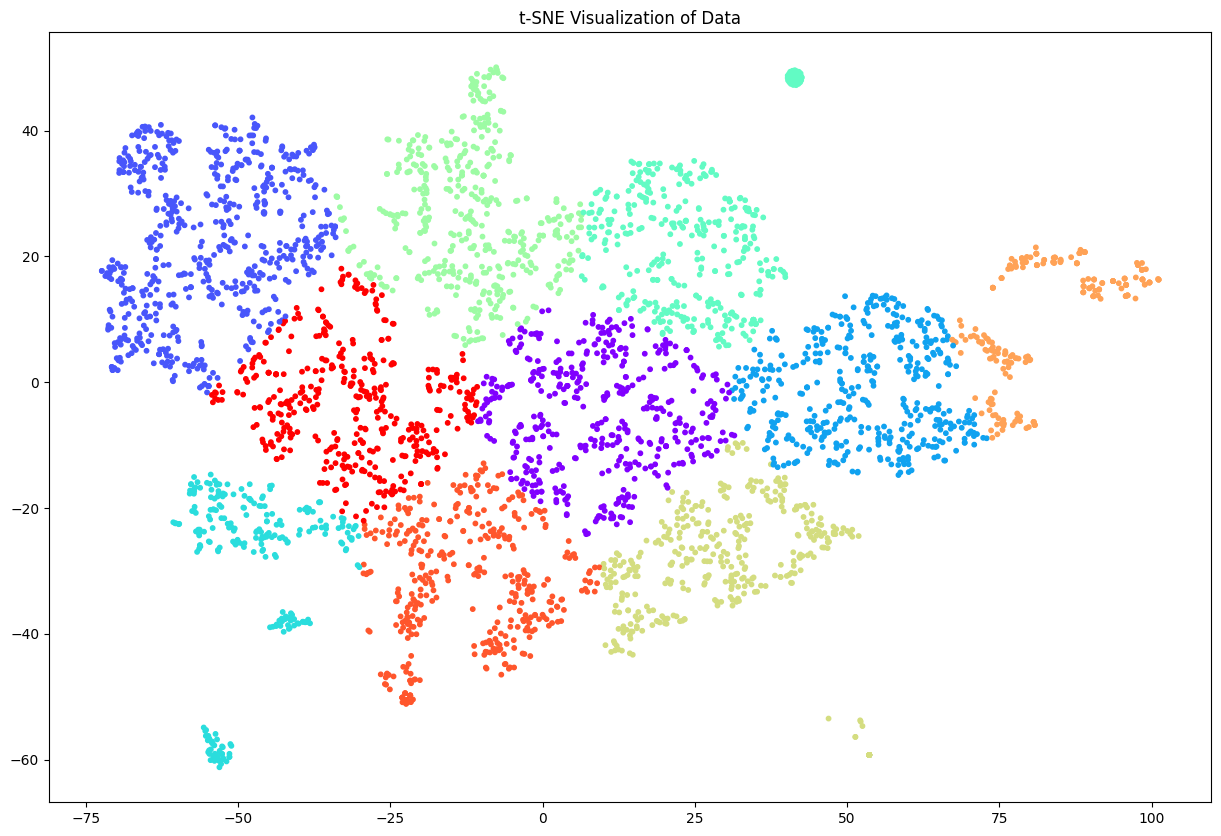

In [42]:
# Perform K-Means clustering to group points by distance
kmeans = KMeans(n_clusters=10, random_state=42)  # You can adjust the number of clusters as needed
labels = kmeans.fit_predict(X_embedded)

plt.figure(figsize=(15, 10))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels, cmap='rainbow', s=10)  # cmap define la paleta de colores
plt.title("t-SNE Visualization of Data")
plt.show()

# Part 3: Ranking

## **Developing our score**

In [26]:
def search_docs_intersection(query,index):
    """
    output is the list of documents that contain all of the query terms.
    So, we will get the list of documents for each query term, and take the intersection of them.
    """
    query = build_terms(query)
    docs = set()
    #initialize
    try:
      docs=set([posting[0] for posting in index[query[0]]])
    except KeyError:
        pass

    for term in query[1:]:
        try:
            # store in term_docs the ids of the docs that contain "term"
            term_docs=[posting[0] for posting in index[term]]
             #inersection to have all docs that contain all the terms
            docs = docs.intersection(term_docs)
        except KeyError:
            #term is not in index
            pass
    docs = list(docs)

    return docs

def rank_documents_our_score(terms, docs, index, idf, tf,tweet_info,delta=0.5):
    """
    Perform the ranking of the results of a search based on the tf-idf weights

    Argument:
    terms -- list of query terms
    docs -- list of tweets, to rank, matching the query
    index -- inverted index data structure
    idf -- inverted document frequencies
    tf -- term frequencies
    title_index -- mapping between page id and page title

    Returns:
    Print the list of ranked documents
    """
    doc_vectors = defaultdict(lambda: [0] * len(terms)) # I call doc_vectors[k] for a nonexistent key k, the key-value pair (k,[0]*len(terms)) will be automatically added to the dictionary
    query_vector = [0] * len(terms)

    likes=[int(tweet_info[doc_num_to_id[i]].split('||')[3]) for i in docs]
    retwets=[int(tweet_info[doc_num_to_id[i]].split('||')[4]) for i in docs]

    # normalize the likes and retwets with z-score normalization
    likes_norm = [(like - np.mean(likes)) / np.std(likes) for like in likes]
    retwets_norm = [(retwet - np.mean(retwets)) / np.std(retwets) for retwet in retwets]

    for termIndex, term in enumerate(terms):  #termIndex is the index of the term in the query
        if term not in index:
            continue
        ## Compute tf*idf(normalize TF as done with documents)
        tf_mean = np.mean([val for val in tf[term]])
        tf_idf_mean = tf_mean * idf[term]
        query_vector[termIndex]=delta*tf[term][termIndex] * idf[term] + (1 - delta)*tf_idf_mean

        # Generate doc_vectors for matching docs
        for doc_index, (doc, postings) in enumerate(index[term]):

            #tf[term][0] will contain the tf of the term "term" in the doc 26
            if doc in docs:
                current_like=(float(tweet_info[doc_num_to_id[doc]].split('||')[3]) - np.mean(likes)) / np.std(likes)
                current_rt=(float(tweet_info[doc_num_to_id[doc]].split('||')[4]) - np.mean(retwets)) / np.std(retwets)
                current_like=(current_like - min(likes_norm)) / (max(likes_norm) - min(likes_norm))
                current_rt=(current_rt - min(retwets_norm)) / (max(retwets_norm) - min(retwets_norm))

                doc_vectors[doc][termIndex] = delta * tf[term][doc_index] * idf[term] + tf_idf_mean*((1 - delta)/2*(current_like) + (1 - delta)/2*(current_rt))



    doc_scores=[[np.dot(curDocVec, query_vector), doc] for doc, curDocVec in doc_vectors.items() ]
    doc_scores.sort(reverse=True)
    result_docs = [x[1] for x in doc_scores]
    if len(result_docs) == 0:
        print("No results found, try again")
        query = input()
        docs = search_tf_idf(query, index)
    return result_docs

def rank_documents(terms, docs, index, idf, tf): 
    # I'm interested only on the element of the docVector corresponding to the query terms
    # The remaining elements would became 0 when multiplied to the query_vector
    doc_vectors = defaultdict(lambda: [0] * len(terms)) # I call doc_vectors[k] for a nonexistent key k, the key-value pair (k,[0]*len(terms)) will be automatically added to the dictionary
    query_vector = [0] * len(terms)

    # compute the norm for the query tf
    query_terms_count = collections.Counter(terms)  # get the frequency of each term in the query.
    # Example: collections.Counter(["hello","hello","world"]) --> Counter({'hello': 2, 'world': 1})
    # HINT: use when computing tf for query_vector

    query_norm = la.norm(list(query_terms_count.values()))

    for termIndex, term in enumerate(terms):  #termIndex is the index of the term in the query
        if term not in index:
            continue

        ## Compute tf*idf(normalize TF as done with documents)

        query_vector[termIndex]=tf[term][termIndex]/np.sqrt(sum(np.power(tf[term],2))) * idf[term]

        # Generate doc_vectors for matching docs
        for doc_index, (doc, postings) in enumerate(index[term]):

            #tf[term][0] will contain the tf of the term "term" in the doc 26
            if doc in docs:
                doc_vectors[doc][termIndex] = tf[term][doc_index] * idf[term]  # TODO: check if multiply for idf



    doc_scores=[[np.dot(curDocVec, query_vector), doc] for doc, curDocVec in doc_vectors.items() ]
    doc_scores.sort(reverse=True)
    result_docs = [x[1] for x in doc_scores]
    #print document titles instead if document id's
    #result_docs=[ title_index[x] for x in result_docs ]
    if len(result_docs) == 0:
        print("No results found, try again")
        query = input()
        docs = search_tf_idf(query, index)
    #print ('\n'.join(result_docs), '\n')
    return result_docs

def rank_documents_our_new_score(terms, docs, index, idf, tf,tweet_info,delta=0.5):
    """
    Perform the ranking of the results of a search based on the tf-idf weights

    Argument:
    terms -- list of query terms
    docs -- list of tweets, to rank, matching the query
    index -- inverted index data structure
    idf -- inverted document frequencies
    tf -- term frequencies
    title_index -- mapping between page id and page title

    Returns:
    Print the list of ranked documents
    """
    doc_vectors = defaultdict(lambda: [0] * (len(terms)+1)) # I call doc_vectors[k] for a nonexistent key k, the key-value pair (k,[0]*len(terms)) will be automatically added to the dictionary
    query_vector = [0] * (len(terms)+1)

    likes=[int(tweet_info[doc_num_to_id[i]].split('||')[3]) for i in docs]
    retwets=[int(tweet_info[doc_num_to_id[i]].split('||')[4]) for i in docs]

    # normalize the likes and retwets with z-score normalization
    likes_norm = [(like - np.mean(likes)) / np.std(likes) for like in likes]
    retwets_norm = [(retwet - np.mean(retwets)) / np.std(retwets) for retwet in retwets]

    for termIndex, term in enumerate(terms):  #termIndex is the index of the term in the query
        if term not in index:
            continue
        query_vector[termIndex]=delta*(tf[term][termIndex]/np.sqrt(sum(np.power(tf[term],2))) * idf[term])

        # Generate doc_vectors for matching docs
        for doc_index, (doc, _) in enumerate(index[term]):
            if doc in docs:
                doc_vectors[doc][termIndex] = delta*(tf[term][doc_index] * idf[term])
    
    # set extra dimension for popularity in docs
    for doc in docs:
        current_like=(float(tweet_info[doc_num_to_id[doc]].split('||')[3]) - np.mean(likes)) / np.std(likes)
        current_rt=(float(tweet_info[doc_num_to_id[doc]].split('||')[4]) - np.mean(retwets)) / np.std(retwets)
        current_like=(current_like - min(likes_norm)) / (max(likes_norm) - min(likes_norm))
        current_rt=(current_rt - min(retwets_norm)) / (max(retwets_norm) - min(retwets_norm))
        doc_vectors[doc][len(terms)] = (1-delta)*(current_like + current_rt)/2

    # set extra dimension for popularity in query
    query_vector[len(terms)] = (1-delta)



    doc_scores=[[np.dot(curDocVec, query_vector), doc] for doc, curDocVec in doc_vectors.items() ]
    doc_scores.sort(reverse=True)
    result_docs = [x[1] for x in doc_scores]
    if len(result_docs) == 0:
        print("No results found, try again")
        query = input()
        docs = search_tf_idf(query, index)
    return result_docs



def rank_documents_w2v(docs,query,tweet_info):

  #calculate all the vectors of the docs that have at least one word
  all_tweets = [tweet_to_array(tweet) for tweet in tweet_info.values()]
  model = Word2Vec(all_tweets, workers=4)

  X = []
  vocabulary = list(model.wv.index_to_key)
  for i in docs:
      tweet=tweet_to_array(tweet_info[(doc_num_to_id[i])] )
      tweet_embedding = []
      for word in tweet:
          if word in vocabulary:
              tweet_embedding.append(model.wv[word])
      if len(tweet_embedding) > 0:
          X.append([np.mean(tweet_embedding, axis=0),i])

  #calculate the query vector
  query_vector = []
  tweet_embedding = []
  for word in query:
      if word in vocabulary:
          tweet_embedding.append(model.wv[word])
  if len(tweet_embedding) > 0:
      query_vector.append(np.mean(tweet_embedding, axis=0))

  #cosinde similarity
  doc_scores=[[np.dot(curDocVec, query_vector[0])/(np.linalg.norm(curDocVec)*np.linalg.norm(query_vector[0])), doc] for  curDocVec,doc in (X) ]
  doc_scores.sort(reverse=True)
  result_docs = [x[1] for x in doc_scores]

  if len(result_docs) == 0:
        print("No results found, try again")

  return result_docs

### Exploratory Data Analysis of our score's performance

In [27]:
def retrieve_scores(terms, docs, index, idf, tf,tweet_info,delta=0.5):
    likes=[int(tweet_info[doc_num_to_id[i]].split('||')[3]) for i in docs]
    retwets=[int(tweet_info[doc_num_to_id[i]].split('||')[4]) for i in docs]

    # normalize the likes and retwets with z-score normalization
    likes_norm = [(like - np.mean(likes)) / np.std(likes) for like in likes]
    retwets_norm = [(retwet - np.mean(retwets)) / np.std(retwets) for retwet in retwets]

    tf_idf_q = [0] * len(terms)
    tf_idf_docs = defaultdict(lambda: [0] * len(terms))
    our_score_q = [0] * len(terms)
    our_score_docs = defaultdict(lambda: [0] * len(terms))

    for termIndex, term in enumerate(terms):  #termIndex is the index of the term in the query
        if term not in index:
            continue
        tf_mean = np.mean([val for val in tf[term]])
        tf_idf_mean = tf_mean * idf[term]
        ## Compute tf*idf(normalize TF as done with documents)
        tf_idf_q[termIndex]= tf[term][termIndex] * idf[term]
        our_score_q[termIndex]=delta * tf[term][termIndex] * idf[term] + (1 - delta) *tf_idf_mean

        # Generate doc_vectors for matching docs
        for doc_index, (doc, postings) in enumerate(index[term]):
            if doc in docs:
                current_like=(float(tweet_info[doc_num_to_id[doc]].split('||')[3]) - np.mean(likes)) / np.std(likes)
                current_rt=(float(tweet_info[doc_num_to_id[doc]].split('||')[4]) - np.mean(retwets)) / np.std(retwets)
                current_like=(current_like - min(likes_norm)) / (max(likes_norm) - min(likes_norm))
                current_rt=(current_rt - min(retwets_norm)) / (max(retwets_norm) - min(retwets_norm))
                tf_idf_docs[doc][termIndex] = tf[term][doc_index] * idf[term]
                our_score_docs[doc][termIndex] = delta * tf[term][doc_index] * idf[term] + \
                                                 ((1 - delta)/2*(current_like) + (1 - delta)/2*(current_rt)) *tf_idf_mean

    # transform the dictionaries into lists
    tf_idf_docs = [tf_idf_docs[doc] for doc in tf_idf_docs]
    our_score_docs = [our_score_docs[doc] for doc in our_score_docs]
    return tf_idf_q, tf_idf_docs, our_score_q, our_score_docs, [(like+retweet)/2 for like, retweet in zip(likes, retwets)]


In [28]:
def plot_scores(term, tf_idf_q, tf_idf_docs, our_score_q, our_score_docs):
    # create a plot with one row and 2 columns, each a histogram, where the first column is for tf-idf scores and the second for our scores, and the query scores fo each are in red
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle('Scores for term: {}'.format(term))
    axs[0].hist(tf_idf_docs, bins=20, label='tf-idf scores')
    axs[0].axvline(x=tf_idf_q, color='red', label='query score')
    axs[0].set_title('tf-idf scores')
    axs[0].legend()
    axs[1].hist(our_score_docs, bins=20, label='our scores')
    axs[1].axvline(x=our_score_q, color='red', label='query score')
    axs[1].set_title('our scores')
    axs[1].legend()
    plt.show()


In [29]:
def get_term_scores(vec_list, termIndex, is_query=False):
    # return all the vectors in the vec list in the position termIndex
    if is_query:
        return vec_list[termIndex]
    return [vec[termIndex] for vec in vec_list]

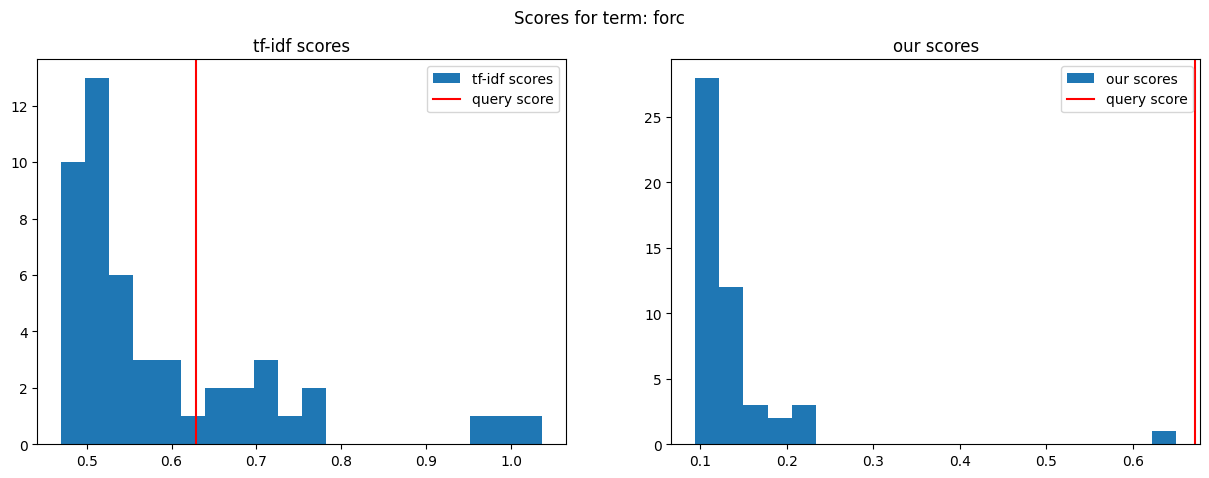

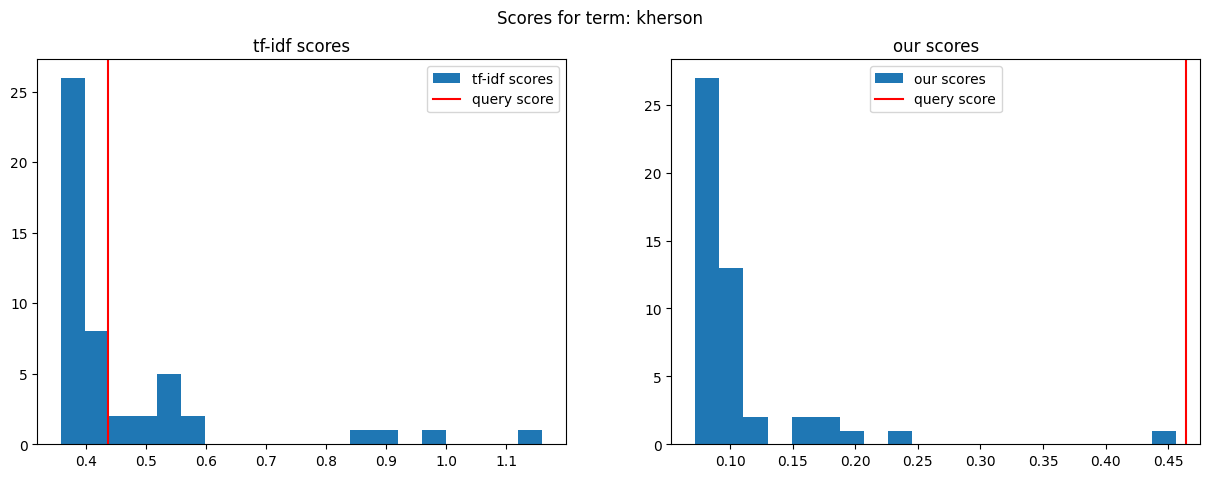

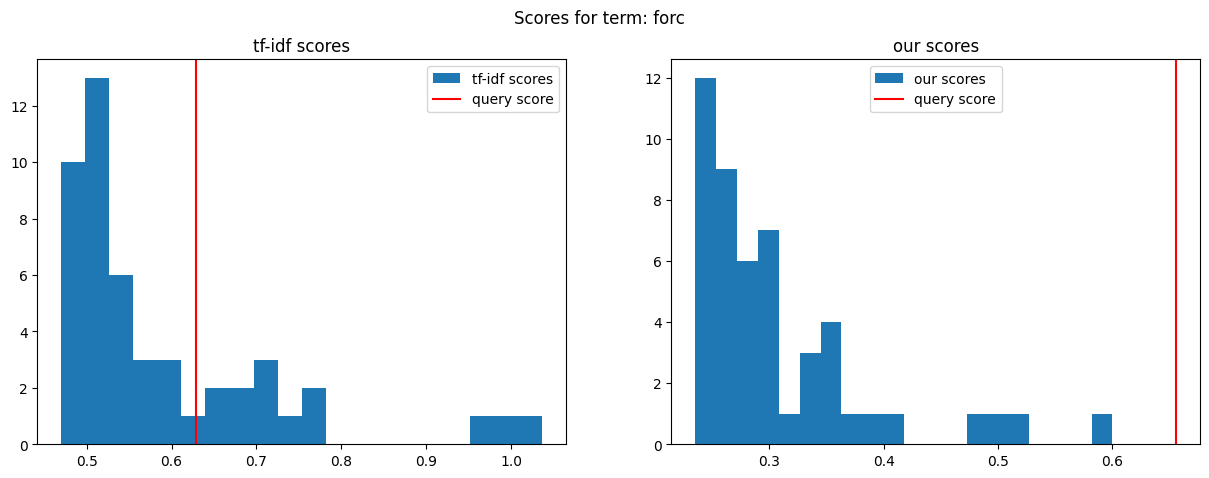

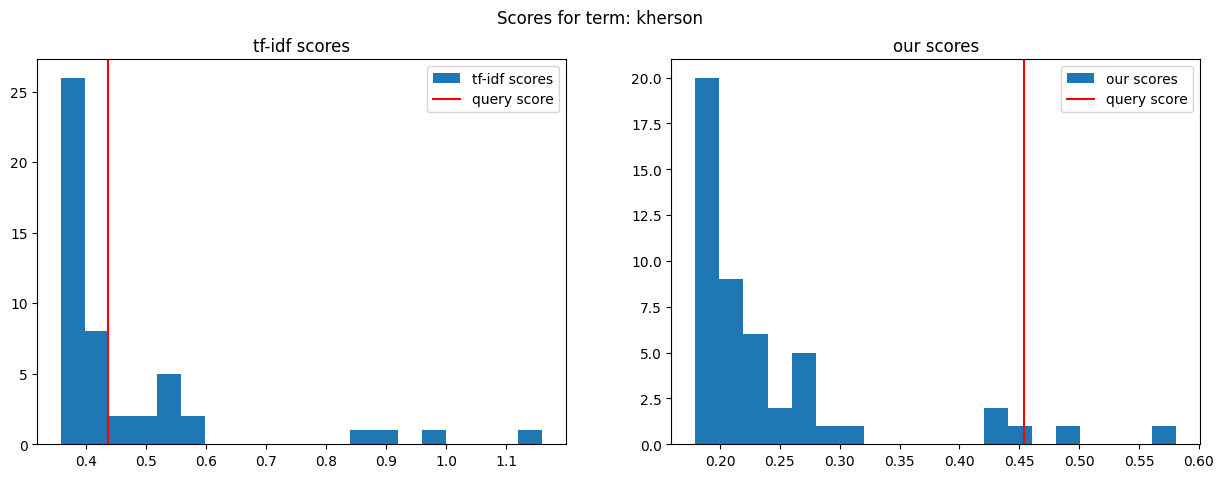

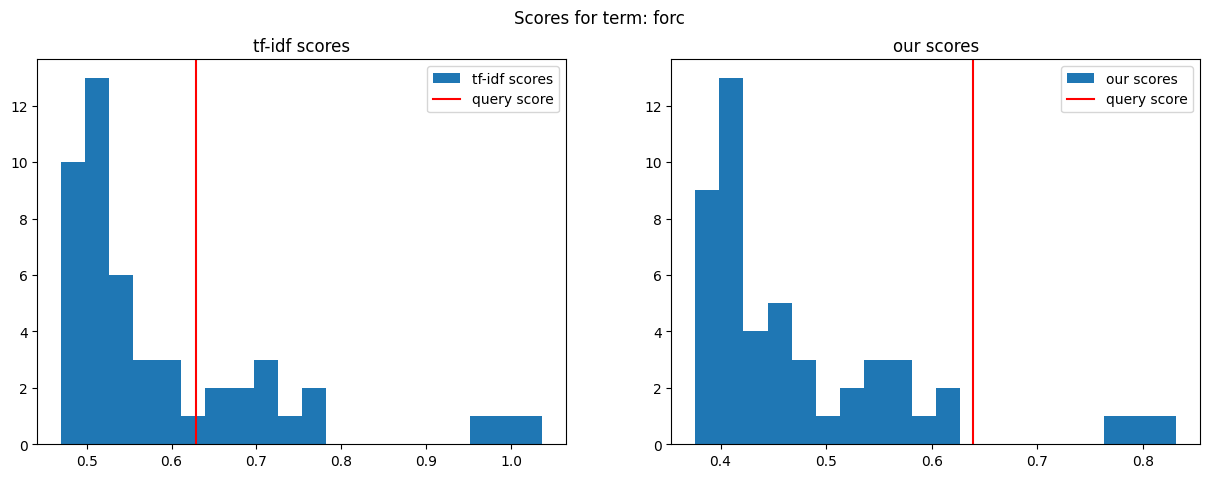

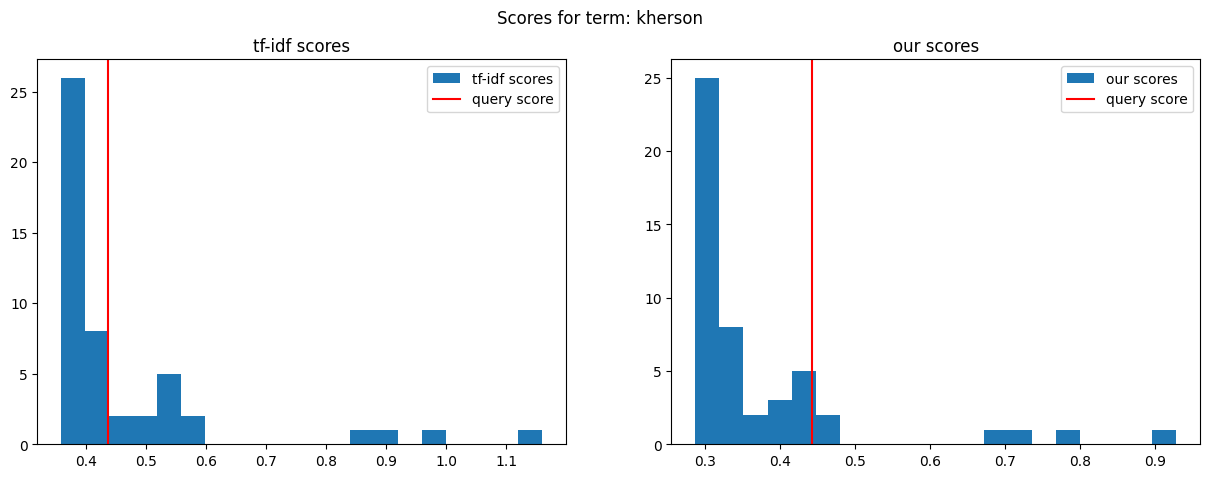

In [30]:
query = our_queries['Q4']

docs=search_docs_intersection(query,index)
query = build_terms(query)
scores_02 = retrieve_scores(query, docs, index, idf, tf, tweet_info, delta=0.2)
scores_05 = retrieve_scores(query, docs, index, idf, tf, tweet_info, delta=0.5)
scores_08 = retrieve_scores(query, docs, index, idf, tf, tweet_info, delta=0.8)


for scores in [scores_02, scores_05, scores_08]:
    tf_idf_q, tf_idf_docs, our_score_q, our_score_docs, lik_ret_scores = scores
    for termIndex, term in enumerate(query):
        tf_idf_q_term, tf_idf_docs_term, our_score_q_term, our_score_docs_term = get_term_scores(tf_idf_q, termIndex, True), \
                                                                                 get_term_scores(tf_idf_docs, termIndex), \
                                                                                 get_term_scores(our_score_q, termIndex, True), \
                                                                                 get_term_scores(our_score_docs, termIndex)
        plot_scores(term, tf_idf_q_term, tf_idf_docs_term, our_score_q_term, our_score_docs_term)

### TF-IDF + cosine similarity

In [31]:
query = our_queries['Q4']

docs=search_docs_intersection(query,index)
query = build_terms(query)
ranked_docs =rank_documents(query, docs, index, idf, tf)
top = 20

print("\n======================\nTop {} results out of {} for the searched query:\n".format(top, len(ranked_docs)))
for d_id in ranked_docs[:top]:
    print("doc_number = {}, relevance of the tweet = {} ".format(d_id,tweet_info[doc_num_to_id[d_id]].split("||")[3:5]))
    print("\n")


Top 20 results out of 49 for the searched query:

doc_number= doc_3589,info_tweet= [' 3 ', ' 1 '] 


doc_number= doc_927,info_tweet= [' 17 ', ' 2 '] 


doc_number= doc_551,info_tweet= [' 15 ', ' 3 '] 


doc_number= doc_1024,info_tweet= [' 20 ', ' 2 '] 


doc_number= doc_1233,info_tweet= [' 8 ', ' 0 '] 


doc_number= doc_3739,info_tweet= [' 2 ', ' 0 '] 


doc_number= doc_1172,info_tweet= [' 90 ', ' 11 '] 


doc_number= doc_3382,info_tweet= [' 4 ', ' 0 '] 


doc_number= doc_2796,info_tweet= [' 2 ', ' 2 '] 


doc_number= doc_2175,info_tweet= [' 0 ', ' 0 '] 


doc_number= doc_2174,info_tweet= [' 0 ', ' 0 '] 


doc_number= doc_2167,info_tweet= [' 1 ', ' 2 '] 


doc_number= doc_922,info_tweet= [' 6 ', ' 0 '] 


doc_number= doc_285,info_tweet= [' 19 ', ' 0 '] 


doc_number= doc_622,info_tweet= [' 0 ', ' 0 '] 


doc_number= doc_1374,info_tweet= [' 15 ', ' 6 '] 


doc_number= doc_620,info_tweet= [' 0 ', ' 0 '] 


doc_number= doc_3578,info_tweet= [' 2 ', ' 1 '] 


doc_number= doc_178,info_tweet

### Your-Score + cosine similarity

This cell implements the imperfect score!!

In [32]:
query = our_queries['Q4']

docs=search_docs_intersection(query,index)
query = build_terms(query)
ranked_docs =rank_documents_our_score(query, docs, index, idf, tf, tweet_info, 1)
top = 20

print("\n======================\nTop {} results out of {} for the searched query:\n".format(top, len(ranked_docs)))
for d_id in ranked_docs[:top]:
    print("doc_number = {}, relevance of the tweet = {} ".format(d_id,tweet_info[doc_num_to_id[d_id]].split('||')[3:5]))
    print("\n")


Top 20 results out of 49 for the searched query:

doc_number= doc_3589,relevance_tweet= [' 3 ', ' 1 '] 


doc_number= doc_1024,relevance_tweet= [' 20 ', ' 2 '] 


doc_number= doc_927,relevance_tweet= [' 17 ', ' 2 '] 


doc_number= doc_551,relevance_tweet= [' 15 ', ' 3 '] 


doc_number= doc_3739,relevance_tweet= [' 2 ', ' 0 '] 


doc_number= doc_1233,relevance_tweet= [' 8 ', ' 0 '] 


doc_number= doc_3382,relevance_tweet= [' 4 ', ' 0 '] 


doc_number= doc_1172,relevance_tweet= [' 90 ', ' 11 '] 


doc_number= doc_2796,relevance_tweet= [' 2 ', ' 2 '] 


doc_number= doc_2175,relevance_tweet= [' 0 ', ' 0 '] 


doc_number= doc_2174,relevance_tweet= [' 0 ', ' 0 '] 


doc_number= doc_2167,relevance_tweet= [' 1 ', ' 2 '] 


doc_number= doc_922,relevance_tweet= [' 6 ', ' 0 '] 


doc_number= doc_285,relevance_tweet= [' 19 ', ' 0 '] 


doc_number= doc_622,relevance_tweet= [' 0 ', ' 0 '] 


doc_number= doc_1374,relevance_tweet= [' 15 ', ' 6 '] 


doc_number= doc_620,relevance_tweet= [' 0 ', ' 0 ']

### Your-Score (new) + cosine similarity

In [33]:
query = our_queries['Q4']

docs=search_docs_intersection(query,index)
query = build_terms(query)
ranked_docs =rank_documents_our_new_score(query, docs, index, idf, tf, tweet_info,0.75)
top = 20

print("\n======================\nTop {} results out of {} for the searched query:\n".format(top, len(ranked_docs)))
for d_id in ranked_docs[:top]:
    print("doc_number = {}, relelvance fo the tweet = {} ".format(d_id,tweet_info[doc_num_to_id[d_id]].split('||')[3:5]))
    print("\n")


Top 20 results out of 49 for the searched query:

doc_number= doc_1533,relelvance_tweet= [' 713 ', ' 184 '] 


doc_number= doc_3589,relelvance_tweet= [' 3 ', ' 1 '] 


doc_number= doc_927,relelvance_tweet= [' 17 ', ' 2 '] 


doc_number= doc_551,relelvance_tweet= [' 15 ', ' 3 '] 


doc_number= doc_1024,relelvance_tweet= [' 20 ', ' 2 '] 


doc_number= doc_1233,relelvance_tweet= [' 8 ', ' 0 '] 


doc_number= doc_1172,relelvance_tweet= [' 90 ', ' 11 '] 


doc_number= doc_3739,relelvance_tweet= [' 2 ', ' 0 '] 


doc_number= doc_3382,relelvance_tweet= [' 4 ', ' 0 '] 


doc_number= doc_2796,relelvance_tweet= [' 2 ', ' 2 '] 


doc_number= doc_2167,relelvance_tweet= [' 1 ', ' 2 '] 


doc_number= doc_2175,relelvance_tweet= [' 0 ', ' 0 '] 


doc_number= doc_2174,relelvance_tweet= [' 0 ', ' 0 '] 


doc_number= doc_285,relelvance_tweet= [' 19 ', ' 0 '] 


doc_number= doc_922,relelvance_tweet= [' 6 ', ' 0 '] 


doc_number= doc_622,relelvance_tweet= [' 0 ', ' 0 '] 


doc_number= doc_1374,relelvance_

## **Word2Vec + cosine similarity**

In [36]:
for (key, query) in our_queries.items():
    docs = search_docs_intersection(query,index)
    ranked_docs = rank_documents_w2v(docs,query,tweet_info)
    top = 20

    print("\n======================\nTop {} results out of {} for the searched query {}:\n".format(top, len(ranked_docs), key))
    # show the top 20 document numbers without showing the text or the info_tweet
    print(ranked_docs[:top])


Top 20 results out of 79 for the searched query Q1:

['doc_1300', 'doc_3391', 'doc_3037', 'doc_87', 'doc_2784', 'doc_2782', 'doc_2781', 'doc_557', 'doc_1803', 'doc_71', 'doc_2794', 'doc_792', 'doc_1823', 'doc_1809', 'doc_1806', 'doc_1801', 'doc_1797', 'doc_1794', 'doc_1787', 'doc_1785']

Top 20 results out of 455 for the searched query Q2:

['doc_105', 'doc_1831', 'doc_3893', 'doc_2169', 'doc_1300', 'doc_69', 'doc_95', 'doc_116', 'doc_74', 'doc_12', 'doc_835', 'doc_244', 'doc_3033', 'doc_1948', 'doc_75', 'doc_1337', 'doc_1496', 'doc_150', 'doc_2110', 'doc_1127']

Top 20 results out of 27 for the searched query Q3:

['doc_1027', 'doc_2525', 'doc_2524', 'doc_2523', 'doc_2522', 'doc_2521', 'doc_2520', 'doc_2519', 'doc_2517', 'doc_2516', 'doc_2515', 'doc_2514', 'doc_2513', 'doc_2512', 'doc_2511', 'doc_2509', 'doc_2507', 'doc_2506', 'doc_2503', 'doc_2502']

Top 20 results out of 49 for the searched query Q4:

['doc_1533', 'doc_1477', 'doc_922', 'doc_3415', 'doc_3409', 'doc_3999', 'doc_1261